In [1]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import mixedlm
from scipy.stats import rankdata
from statsmodels.stats.multitest import multipletests
import random
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, squareform
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
otu_table = pd.read_csv('real_datasets/otu_table.csv', index_col = [0])
metadata_table = pd.read_csv('real_datasets/metadata.csv', index_col = [0])

In [4]:
metadata_table.head()

,Individual,Timepoint,Study
SRR15511287,BarberC_20211,After,BarberC_2021
SRR15511286,BarberC_20211,Before,BarberC_2021
SRR15511280,BarberC_202110,After,BarberC_2021
SRR15511279,BarberC_202110,Before,BarberC_2021
SRR15511278,BarberC_202111,After,BarberC_2021


In [5]:
[metadata_table.query("Study == @study").shape[0] for study in metadata_table.Study.unique()]

[30, 24, 48, 36, 100, 26]

In [6]:
metadata_table.Study.unique()

array(['BarberC_2021', 'DelannoyBrunoO_2021',
       'DelannoyBrunoO_2022_Orange', 'DelannoyBrunoO_2022_Pea',
       'NiY_2023', 'WastykHC_2021'], dtype=object)

In [7]:
metadata_table['timepoint_int'] = metadata_table.Timepoint.map({"Before": 0, 'After':1})

In [8]:
subject_dict = dict(zip(metadata_table.index, metadata_table.Individual))
timepoint_dict = dict(zip(metadata_table.index, metadata_table.timepoint_int))
study_dict = dict(zip(metadata_table.index, metadata_table.Study))

In [9]:
# filter counts
PA_filter = (otu_table
             .astype(bool)
             .astype(int)
             .sum(axis=1)
             .reset_index()
             .rename({0:'N'}, axis=1)
            )

PA_filtered_data = otu_table.loc[PA_filter[PA_filter['N'] > int(otu_table.shape[0]*0.05)]['index']]

In [10]:
# change to relative abundance
relab_data = PA_filtered_data.div(PA_filtered_data.sum(axis=0), axis=1)

In [11]:
# Calculate mean abundance
mean_relab_data = relab_data.mean(axis=1).reset_index().rename({0:'N'}, axis=1)

In [12]:
# Keep bacteria with high abundance
keep_relab_bacteria = mean_relab_data.query("N > 1e-3")['index']

In [13]:
RelAB_filtered_data = PA_filtered_data.loc[keep_relab_bacteria]
relab_counts = RelAB_filtered_data.div(RelAB_filtered_data.sum(axis=0), axis=1).T

In [14]:
relab_counts.to_csv('otu_table_filtered.csv')

## Run model

In [32]:
def run_lmm(N, study, i):
    
    idx_before = metadata_table.query("Study == @study and Timepoint == 'Before'").sample(N).index.tolist()
    idx_after = metadata_table.query("Study == @study and Timepoint == 'After'").sample(N).index.tolist()
    idx = idx_before + idx_after
    
    subsampled_dataset = relab_counts.loc[idx]
    
    results = []
    
    for feature in keep_relab_bacteria:
        try:
            df = pd.DataFrame(rankdata(np.log(subsampled_dataset[feature] + 1e-3)),
                              columns=['feature'], index=subsampled_dataset.index)
            
            df['timepoint'] = df.index.map(timepoint_dict).astype('category')
            df['subject'] = df.index.map(subject_dict)
            df['study'] = df.index.map(study_dict).astype('category')
            
            model = mixedlm("feature ~ timepoint", data=df, groups=df["subject"])
            result = model.fit()
            
            pvalue = result.pvalues.get('timepoint[T.1]', np.nan)
            
            results.append({
                "dataset":study,
                "feature": feature,
                "pvalue": pvalue,
                "N": N,
                "rep": i
            })
            
        except:
            
            results.append({
                "dataset":study,
                "feature": feature,
                "pvalue": np.nan,
                "N": N,
                "rep": i
            })
            
        
    results_df = pd.DataFrame(results)
    results_df['qval']  = np.round(multipletests(results_df.pvalue.fillna(1), method='fdr_bh')[1], 3)
    results_df['ypred'] = np.where(results_df.qval < 0.2, 1, 0)
    
    return results_df

In [33]:
Studies = metadata_table.Study.unique()
Reps = range(1, 5)
N_vals = [5, 10, 15, 20]

RESULTS = []
for study in Studies:
    for rep in Reps:
        for n in N_vals:


            if n*2 > metadata_table.query("Study == @study").shape[0]:
                continue  # skip this iteration

            d = run_lmm(n, study, rep)
            RESULTS.append(d)

In [34]:
RESULTS_DF = pd.concat(RESULTS)

In [35]:
df = (RESULTS_DF
      .drop(columns = ['feature'])
      .groupby(by = ['dataset', 'N', 'rep'])
      .sum()
      .groupby(by = ['dataset', 'N'])
      .mean()
     .reset_index()
     )
df.head()

,dataset,N,pvalue,qval,ypred
0,BarberC_2021,5,18.442820,28.03425,24.75
1,BarberC_2021,10,17.570213,25.36350,17.50
2,BarberC_2021,15,14.825958,20.16100,27.00
3,DelannoyBrunoO_2021,5,21.061561,31.84625,15.00
4,DelannoyBrunoO_2021,10,22.364649,34.41025,7.00


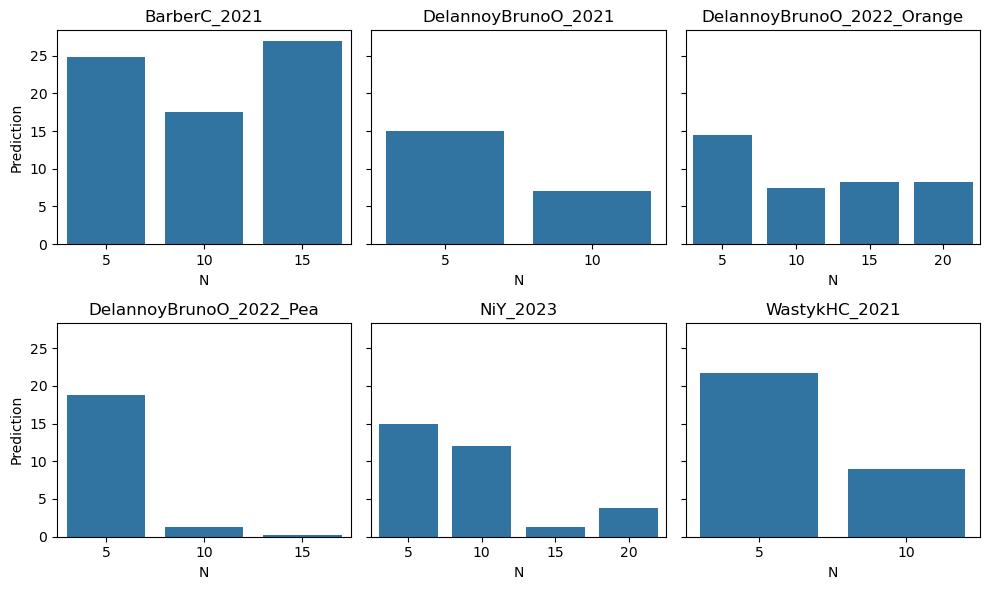

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6), sharey=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each dataset in its subplot
for ax, dataset in zip(axes, Studies):
    sns.barplot(data=df.query("dataset == @dataset"), x='N', y='ypred', ax=ax)
    ax.set_title(dataset)
    ax.set_xlabel("N")
    ax.set_ylabel("Prediction")

# Adjust layout
plt.tight_layout()
plt.savefig('/Users/zkarwowska/Desktop/EMBL_project/real_datasets_plot.png', dpi=300)
plt.show()

In [37]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
N_vals = [5, 10, 15, 20]

jaccard_res = []

for dataset in Studies:
    for n in N_vals:
        try:
            # Filter results for current dataset and sample size
            filtered = RESULTS_DF.query("dataset == @dataset and N == @n")
            
            # Get available replicates
            reps = sorted(filtered['rep'].unique())
            if len(reps) < 2:
                continue  # Skip if fewer than 2 replicates

            # Build dataframe of ypreds per replicate
            rep_dfs = [
                filtered.query("rep == @rep")[['feature', 'ypred']]
                    .set_index('feature')
                    .rename(columns={'ypred': f'ypred_{rep}'})
                for rep in reps
            ]
            
            df = pd.concat(rep_dfs, axis=1).fillna(0)  # Assumes binary ypred

            # Compute Jaccard distance between replicates
            jaccard_matrix = squareform(pdist(df.T, metric='jaccard'))

            # Mean of upper triangle (excluding diagonal)
            triu_vals = jaccard_matrix[np.triu_indices_from(jaccard_matrix, k=1)]
            mean_jaccard = triu_vals.mean()

            jaccard_res.append({
                "dataset": dataset,
                "N": n,
                "mean_jaccard": mean_jaccard
            })

        except Exception as e:
            print(f"Error for dataset={dataset}, N={n}: {e}")


In [38]:
jaccard_results_df = pd.DataFrame(jaccard_res)

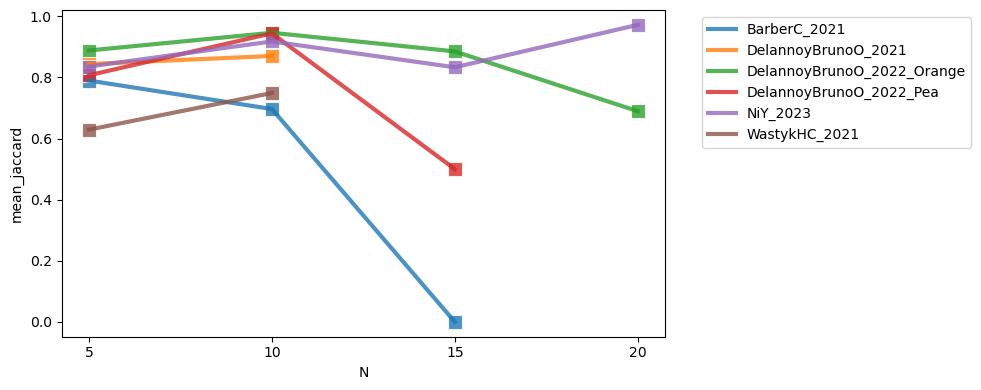

In [39]:
plt.figure(figsize = (10, 4))
sns.lineplot(data = jaccard_results_df, x = jaccard_results_df.N.astype(str), y = 'mean_jaccard', hue = 'dataset', lw=3, alpha=.8)
sns.scatterplot(data = jaccard_results_df, x = jaccard_results_df.N.astype(str), y = 'mean_jaccard', hue = 'dataset', legend=False, s=100, 
                alpha = .8, marker = 's')

plt.legend(bbox_to_anchor = (1.05, 1))
plt.tight_layout()
plt.savefig('/Users/zkarwowska/Desktop/EMBL_project/real_datasets_plot2.png', dpi=300)


## Run on all studies

In [40]:
studies = ['BarberC_2021', 'DelannoyBrunoO_2022_Orange', 'DelannoyBrunoO_2022_Pea', 'NiY_2023']

In [61]:
results = []

for n in [5, 10, 15]:
    try:

        idx_b = [i for study in studies
               for i in metadata_table.query("Study == @study and Timepoint == 'Before'").sample(n).index.tolist()]
        
        idx_a = [i for study in studies
               for i in metadata_table.query("Study == @study and Timepoint == 'After'").sample(n).index.tolist()]
        
        subsampled_data = relab_counts.loc[idx_b + idx_a]

        features_res = []
        for feature in keep_relab_bacteria:
            df = pd.DataFrame(rankdata(np.log(subsampled_data[feature] + 1e-3)),
                              columns=['feature'], index=subsampled_data.index)
            
            df['timepoint'] = df.index.map(timepoint_dict).astype('category')
            df['subject'] = df.index.map(subject_dict)
            df['study'] = df.index.map(study_dict).astype('category')

            model = mixedlm("feature ~ timepoint + study", data=df, groups=df["subject"])
            result = model.fit()
            
            pvalue = result.pvalues.get('timepoint[T.1]', np.nan)

            features_res.append(
                {"feature": feature,
                 "pvalue": pvalue,
                 "N": n
                }
            )
            
        results_df = pd.DataFrame(features_res)
        results_df['qval']  = np.round(multipletests(results_df.pvalue.fillna(1), method='fdr_bh')[1], 3)
        results_df['ypred'] = np.where(results_df.qval < 0.2, 1, 0)
        results.append(results_df)
        
    except Exception as e:
        print(f"Error at N={n}: {e}")


In [62]:
plot_df = results_df.iloc[:, 1:].groupby(by = ['N']).sum().reset_index().groupby(by = 'N').mean().reset_index()
plot_df['N'] = plot_df.N * 2
plot_df['N'] = plot_df.N.astype(str)

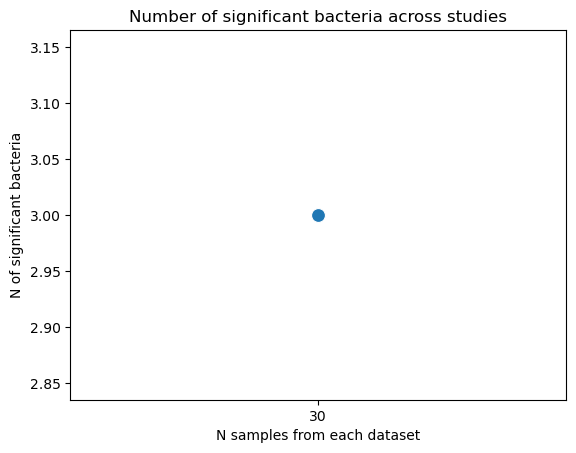

In [63]:
sns.lineplot(data = plot_df, x = 'N', y = 'ypred', lw=2)
sns.scatterplot(data = plot_df, x = 'N', y = 'ypred', s=100)

plt.title('Number of significant bacteria across studies')
plt.xlabel("N samples from each dataset")
plt.ylabel("N of significant bacteria")

plt.savefig('/Users/zkarwowska/Desktop/EMBL_project/real_datasets_plot3.png', dpi=300)